In [138]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [139]:
#Data loading
train = pd.read_csv("/Users/navyasree/Desktop/NYC/train.csv")
test = pd.read_csv("/Users/navyasree/Desktop/NYC/test.csv")
#Cleaning of data
train.dropna(how = 'any', axis = 'rows', inplace = True)

train = train[(train.passenger_count>0) & (train.passenger_count<=6)]

train = train[(train.distance!=0) & (train.fare_amount!=0)]

train = train[(40<=train.pickup_latitude) & (train.pickup_latitude<=41)]
train = train[(-75<=train.pickup_longitude) & (train.pickup_longitude<=-73)]
train = train[(40<=train.dropoff_latitude) & (train.dropoff_latitude<=41)]
train = train[(-75<=train.dropoff_longitude) & (train.dropoff_longitude<=-73)]

train = train[((train.pickup_latitude-train.dropoff_latitude).abs()!=0) & ((train.pickup_longitude-train.dropoff_longitude).abs()!=0)]

train = train[train.fare_amount>=2.5]

In [146]:
def haversine_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    R = 6371#radius of earth in kms
    total = [train,test]
    for i in total:
        pickup_lat = np.radians(i[pickup_latitude])
        dropoff_lat = np.radians(i[dropoff_latitude])
        diff_lat = np.radians(i[dropoff_latitude]-i[pickup_latitude])
        diff_lon = np.radians(i[dropoff_longitude]-i[pickup_longitude])
        a = np.sin(diff_lat/2)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(diff_lon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = (R * c) #in kilometers
        i['distance'] = d
        i['duration'] = d/7.56 #7.56kmph is considered as approximate aversge velocity of a taxi in new york city
    return d

In [ ]:
#Calculating the haversine distance between the pickup and dropoff coordinates and also calculate the approximate duration of the trip
train['distance'] = 0
test['distance'] = 0
train['duration'] = 0
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')


In [149]:
#Extracting the following features from pickup_datetime
train['year'] = pd.DatetimeIndex(train['pickup_datetime']).year
train['month'] = pd.DatetimeIndex(train['pickup_datetime']).month
train['day'] = pd.DatetimeIndex(train['pickup_datetime']).day
train['hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
train['minute'] = pd.DatetimeIndex(train['pickup_datetime']).minute
train['second'] = pd.DatetimeIndex(train['pickup_datetime']).second
train['weekday'] = pd.DatetimeIndex(train['pickup_datetime']).weekday

test['year'] = pd.DatetimeIndex(test['pickup_datetime']).year
test['month'] = pd.DatetimeIndex(test['pickup_datetime']).month
test['day'] = pd.DatetimeIndex(test['pickup_datetime']).day
test['hour'] = pd.DatetimeIndex(test['pickup_datetime']).hour
test['minute'] = pd.DatetimeIndex(test['pickup_datetime']).minute
test['second'] = pd.DatetimeIndex(test['pickup_datetime']).second
test['weekday'] = pd.DatetimeIndex(test['pickup_datetime']).weekday



In [212]:
#Processing the extra data set taken
yellowTaxiData = pd.read_csv("/Users/navyasree/Desktop/NYC/yellow_taxi_data.csv")
yellowTaxiData.dropna(how = 'any', axis = 'rows', inplace = True)
yellowTaxiData = yellowTaxiData[(train.passenger_count>0) & (yellowTaxiData.passenger_count<=6)]
yellowTaxiData = yellowTaxiData[['passenger_count','trip_distance','tpep_pickup_datetime','tpep_dropoff_datetime','fare_amount']]
yellowTaxiData.rename(columns={'trip_distance': 'distance', 'tpep_pickup_datetime': 'pickup_datetime','tpep_dropoff_datetime': 'dropoff_datetime'}, inplace=True)


yellowTaxiData['year'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).year
yellowTaxiData['month'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).month
yellowTaxiData['day'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).day
yellowTaxiData['hour'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).hour
yellowTaxiData['minute'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).minute
yellowTaxiData['second'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).second
yellowTaxiData['weekday'] = pd.DatetimeIndex(yellowTaxiData['pickup_datetime']).weekday
yellowTaxiData['dropoff_hour'] = pd.DatetimeIndex(yellowTaxiData['dropoff_datetime']).hour
yellowTaxiData['dropoff_minute'] = pd.DatetimeIndex(yellowTaxiData['dropoff_datetime']).minute


In [196]:
def duration(hour, minute, dropoff_hour, dropoff_minute):
    
    data = [yellowTaxiData]
    for i in data:
        ph = i[hour]
        pm = i[minute]
        dh = i[dropoff_hour]
        dm = i[dropoff_minute]
        
        t = (60*dh+dm) - (60*ph+pm)
        i['duration'] = t
    return t

In [ ]:
#Calculating the duration of the trip for extra dataset
yellowTaxiData['duration'] = 0
duration('hour','minute','dropoff_hour','dropoff_minute')

In [198]:
#method to calculate the time of pickup
def time(hour, minute):
    
    total = [train,test]
    for i in total:
        h = i[hour]
        m = i[minute]
        t = (60*h+m) 
        i['time'] = t
        
    return t

In [ ]:
#Calculating the time of the trip for training dataset
time('hour','minute')

In [ ]:
#Creating the X_train,y_train and X_test
feature_columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','distance','passenger_count','year','month','day','hour','minute','second','time','weekday']
train_feature = train[feature_columns]
train_fare = train['fare_amount']
test_columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','distance','passenger_count','year','month','day','hour','minute','second','time','weekday']
test_set = test[test_columns]

In [173]:
#Predicting the results using the trained and test data across LinearRegression
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
linearReg.fit(train_feature,train_fare)
fare_predict = linearReg.predict(test_set)
linearReg.score(test_set,fare_predict)
test_output = pd.read_csv("/Users/navyasree/Desktop/NYC/sample_submission.csv")
test_output['fare_amount']=fare_predict
test_output.to_csv("/Users/navyasree/Desktop/NYC/sample_submission_lr.csv", index = False)

In [174]:
#Predicting the results using the trained and test data across GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_feature,train_fare)
fare_predict = gbr.predict(test_set)
gbr.score(test_set,fare_predict)
test_output = pd.read_csv("/Users/navyasree/Desktop/NYC/sample_submission.csv")
test_output['fare_amount']=fare_predict
test_output.to_csv("/Users/navyasree/Desktop/NYC/sample_submission_gbr.csv", index = False)

In [175]:
#Predicting the results using the trained and test data across RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_feature, train_fare)
fare_predict = rf.predict(test_set)
rf.score(test_set,fare_predict)
test_output = pd.read_csv("/Users/navyasree/Desktop/NYC/sample_submission.csv")
test_output['fare_amount']=fare_predict
test_output.to_csv("/Users/navyasree/Desktop/NYC/sample_submission_rfr.csv", index = False)

In [219]:
#Merging the extra dataset with the training set
yellowTaxiCoulmns=yellowTaxiData[['distance','passenger_count','year','month','day','hour','minute','second','weekday','duration','fare_amount']]
trainColumns=train[['distance','passenger_count','year','month','day','hour','minute','second','weekday','duration','fare_amount']]
sets = [yellowTaxiCoulmns,trainColumns]
trainAndYellowTaxi = pd.concat(sets)

In [222]:
#Predicting the results using the trained(extra dataset+train set) and test data across RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

test_columns=['distance','passenger_count','year','month','day','hour','minute','second','weekday','duration']
test_set = test[test_columns]
feature_columns=['distance','passenger_count','year','month','day','hour','minute','second','weekday','duration']
train_feature = trainAndYellowTaxi[feature_columns]
train_fare = trainAndYellowTaxi['fare_amount']
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_feature, train_fare)
fare_predict = rf.predict(test_set)
rf.score(test_set,fare_predict)
test_output = pd.read_csv("/Users/navyasree/Desktop/NYC/sample_submission.csv")
test_output['fare_amount']=fare_predict
test_output.to_csv("/Users/navyasree/Desktop/NYC/sample_submission_rfr_extradata.csv", index = False)




In [43]:
#Predicting the results using the trained and test data across XGBRegressor

xgbReg=xgb.XGBRegressor()
xgbReg.fit(train_feature, train_fare)
fare_predict = xgbReg.predict(test_set)
#Writing results to the output file
test_output = pd.read_csv("/Users/navyasree/Desktop/NYC/sample_submission.csv")
test_output['fare_amount']=fare_predict
test_output.to_csv("/Users/navyasree/Desktop/NYC/sample_submission_xgb.csv", index = False)

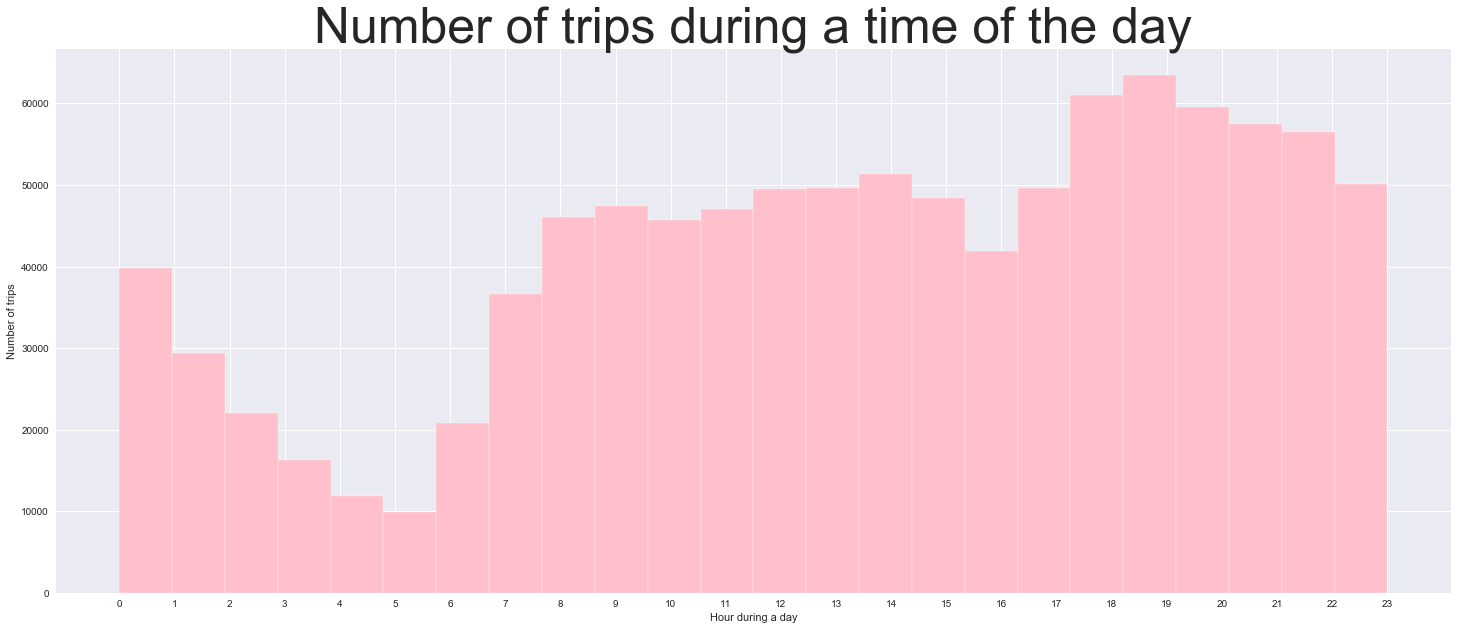

In [242]:

# Plot of number of trips during a day
plt.figure(figsize=(25,10),facecolor='white')
plt.hist(train.hour, bins = 24, color=['pink'],ec='white')
plt.xticks(np.arange(0, 24, step = 1))
plt.title("Number of trips during a time of the day", fontsize = 50)
plt.xlabel('Hour during a day')
plt.ylabel('Number of trips')
plt.show()

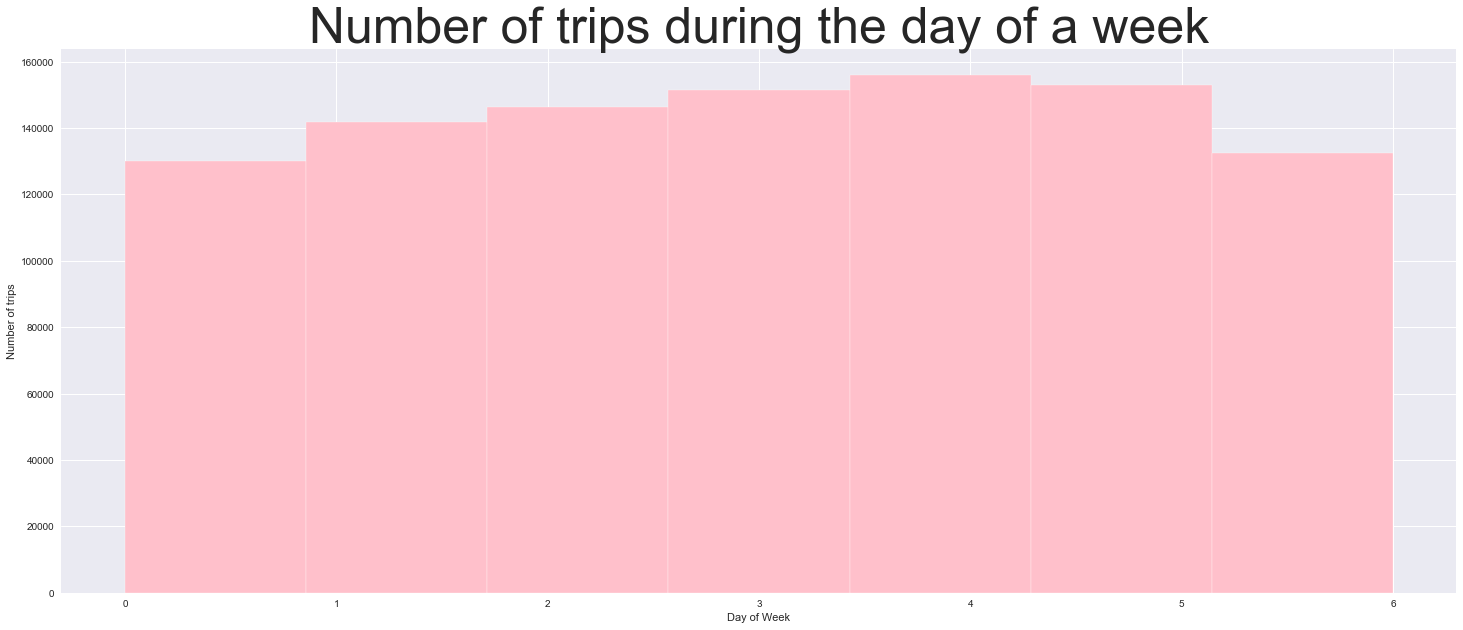

In [243]:
# Plot of number of trips during a day
plt.figure(figsize=(25,10),facecolor='white')
plt.hist(train.weekday, bins = 7, color=['pink'], ec='white')
plt.xlabel('Day of Week')
plt.ylabel('Number of trips')
plt.title("Number of trips during the day of a week", fontsize = 50)
plt.show()

In [184]:
import scipy
scipy.stats.pearsonr(train['distance'], train['fare_amount'])

(0.8705987291115088, 0.0)

In [185]:
scipy.stats.pearsonr(train['hour'], train['distance'])

(-0.03210128464404107, 9.183607468154235e-229)

In [186]:
scipy.stats.pearsonr(train['hour'], train['fare_amount'])

(-0.01890854260837521, 1.2233685138795993e-80)

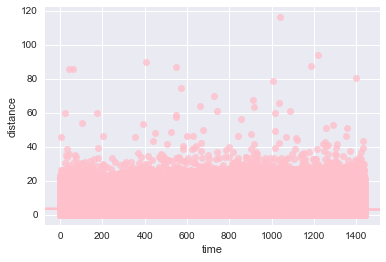

In [181]:
import seaborn as sns
sns.set_palette('hls')
sns.set(color_codes=True)
graph = sns.regplot(x=train.time, y=train.distance, data=train, color = 'pink')

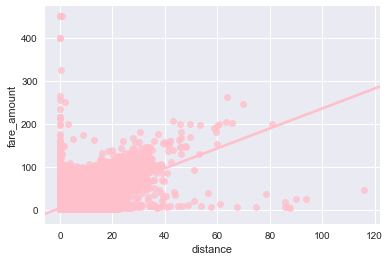

In [182]:
sns.set_palette("hls",8)
sns.set(color_codes=True) 
graph = sns.regplot(x="distance", y="fare_amount", data=train, color = 'pink')


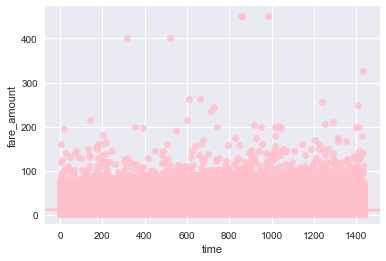

In [183]:
sns.set_palette("hls")
sns.set(color_codes=True)
graph = sns.regplot(x="time", y="fare_amount", data=train, color = 'pink')


In [247]:
#Linear regression model to calculate the cooefficients and error metrics
import sklearn
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn import linear_model
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
columns=['distance','passenger_count','year','month','day','hour','minute','second','time','weekday']
train_feature = train[columns]
train_fare = train['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_fare, test_size=0.2)

linearmodel = linear_model.LinearRegression()
model = linearmodel.fit(X_train, y_train)
fare_predict = linearmodel.predict(X_test)

print("Coefficients of the model : ", linearmodel.coef_)
print("Root Mean Square Error : ", np.sqrt(metrics.mean_squared_error(y_test, fare_predict)))
print("R^2 Value : ", r2_score(y_test, fare_predict))


Coefficients of the model :  [ 2.31417761e+00  1.97324891e-02  5.27753503e-01  7.17659259e-02
  9.03634016e-04  2.36847651e-05 -1.24242717e-03 -2.65123653e-03
  1.78658737e-04 -5.45399328e-02]
Root Mean Square Error :  4.671775093773364
R^2 Value :  0.7621601988619195
